# Assingment 1

In [3]:
#!pip install -U scikit-learn pandas matplotlib

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from os import walk
import pathlib
import shutil
import tempfile
from sklearn.utils import resample

# from  IPython import display
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
# CSS = """
# .output {
#     flex-direction: row;
# }
# """

# HTML('<style>{}</style>'.format(CSS))
pd.set_option('display.max_columns', None)
AUTOTUNE=tf.data.experimental.AUTOTUNE

In [5]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU

# Data Retrival

## Reading Dataset files

In [6]:
# # Clone the entire repo.
# !git clone -l -s git://github.com/milindparvatia/DL-Assingment-1.git
# %cd DL-Assingment-1
# !ls

### 1) Training dataset

In [7]:
train_df = pd.read_csv('train_data.csv')
train_df.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


In [8]:
print("Shape of training dataset:",train_df.shape)

Shape of training dataset: (2325, 5)


### 2) Testing Dataset

In [9]:
test_df = pd.read_csv('test_data.csv')
test_df.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [10]:
print("Shape of testing dataset:",test_df.shape)

Shape of testing dataset: (465, 3)


## Clean dataset

In [11]:
train_df.isnull().sum()

filename     0
person_id    0
series       0
tilt         0
pan          0
dtype: int64

In [12]:
test_df.isnull().sum()

filename     0
person_id    0
series       0
dtype: int64

## Accessing Images Data

In [13]:
curr_dir = os.getcwd()
image_names = []

if os.path.exists(curr_dir+"/faces"):
    images_dir = curr_dir+"/faces"
    
    for (dirpath, dirnames, filenames) in walk(images_dir):
        image_names.extend(filenames)
        break

    for i, name in enumerate(image_names):
        train_df['filename'] = train_df['filename'].replace('face_'+str(name), name)
        test_df['filename'] = test_df['filename'].replace('face_'+str(name), name)

else:
    os.mkdir('faces')
    images_dir = pathlib.Path(curr_dir+"/modified_data")
    
    for (dirpath, dirnames, filenames) in walk(images_dir):
        image_names.extend(filenames)
        break
            
    for i, name in enumerate(image_names):
        new_name = "_".join(name.split('_')[1:2])
        
        old_path = str(images_dir)+"/"+name
        new_path = os.path.join(curr_dir+"/faces/", new_name)
        os.rename(old_path, new_path)
        
        train_df['filename'] = train_df['filename'].replace(str(name), new_name)
        test_df['filename'] = test_df['filename'].replace(str(name), new_name)
        
    images_dir = curr_dir+"/faces/"
    
train_image_count = len(list(pathlib.Path(images_dir).glob('*.jpg')))
print("Total numbers of Images we have to process are",train_image_count)

Total numbers of Images we have to process are 2790


In [14]:
logdir = os.getcwd()+'\logs'
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

print(logdir)

# Open an embedded TensorBoard viewer
%tensorboard --logdir 'C:\Users\Milind\DL-Assingment-1\logs' #{logdir}

C:\Users\Milind\DL-Assingment-1\logs


Reusing TensorBoard on port 6006 (pid 3796), started 0:12:55 ago. (Use '!kill 3796' to kill it.)

In [15]:
## I have conver filenames to int to make it easier to fir into tf.data
train_df.head()

,filename,person_id,series,tilt,pan
0,0.jpg,5,1,-15,30
1,1.jpg,5,1,0,-75
2,2.jpg,5,2,-15,-60
3,3.jpg,5,2,0,-90
4,4.jpg,5,2,15,-75


From the above measurements we can conclude that the Given datasets have zero null values and are in perfect condition for further processing.

# Data Preparation

I have took following steps to prepare training and testing datasets which will be later used for NeuroNet classification.

## 1) Checking Frequencies of Labels
https://elitedatascience.com/imbalanced-classes

- Our main goal is to predict face's tilt and pan angle from given images, to do that, so we have to make sure that if all the labels of given classes are balanced(e.g. equals in numbers compared to other labels), if they're imbalanced then we have to handle imbalance classes with Different sampling strategies.

- So, lets examine the Frequency of labels for both classes pan and tilt in the given dataset.

 15    325
-15    325
 60    325
-60    325
 30    325
-30    325
 0     325
 90     25
-90     25
Name: tilt, dtype: int64

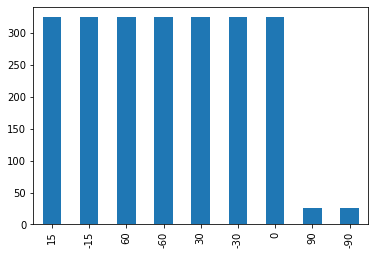

In [16]:
fig, ax = plt.subplots()
train_df['tilt'].value_counts().plot(ax=ax, kind='bar')

train_df['tilt'].value_counts()

 0     225
 75    175
-75    175
 45    175
-45    175
 15    175
-15    175
 90    175
-90    175
 60    175
-60    175
 30    175
-30    175
Name: pan, dtype: int64

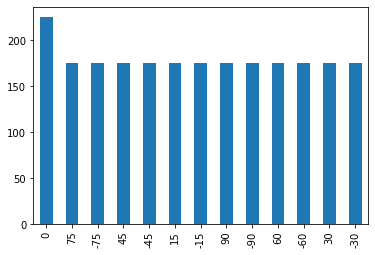

In [17]:
fig, ax = plt.subplots()
train_df['pan'].value_counts().plot(ax=ax, kind='bar')
train_df['pan'].value_counts()

- From the above histograms we can say that values **[90,-90]** in **tilt column** and value **[0]** in **pan column** are imbalance from other labels in their respective class. 


- Since the dataset is imbalance we have to perform re-sampling to make all sets of label balanced.

here I'm checking other class's frequency so that we can understand which type of strategy to use for resampling

### frequency of [tilt == 90]'s relative class labels

In [18]:
train_df[train_df.tilt==90]['pan'].value_counts()

0    25
Name: pan, dtype: int64

### frequency of [tilt == - 90]'s relative class labels

In [19]:
train_df[train_df.tilt==-90]['pan'].value_counts()

0    25
Name: pan, dtype: int64

### frequency of [pan == 0]'s relative class labels

In [20]:
train_df[train_df.pan==0]['tilt'].value_counts()

 90    25
-90    25
 60    25
-60    25
 30    25
-30    25
 15    25
-15    25
 0     25
Name: tilt, dtype: int64

- From these value counts we can safely say that in case of tilt == 90 and -90, they both shares same relative class label which is 0. In this case we can easily up sample this rows to 325 to match other label's value count.

- While in case of pan == 0, it share's all the other labels relatively so we can down-scale in this case to 175 from 225 to match all the other classes' value count.

### 1) Up-Scaling Tilt's Label [90]

In [21]:
# Separate majority and minority classes
df_majority = train_df[train_df.tilt!=90]
df_minority = train_df[train_df.tilt==90]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=325,    # to match majority class
                                 random_state=425) # reproducible results
 
# Combine majority class with upsampled minority class
train_df = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
train_df.tilt.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

 15    325
-15    325
 90    325
 60    325
-60    325
 30    325
-30    325
 0     325
-90     25
Name: tilt, dtype: int64

### 2) Up-Scaling Tilt's Label [-90]

In [22]:
# Separate majority and minority classes
df_majority = train_df[train_df.tilt!=-90]
df_minority = train_df[train_df.tilt==-90]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=325,    # to match majority class
                                 random_state=425) # reproducible results
 
# Combine majority class with upsampled minority class
train_df = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
train_df.tilt.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

 15    325
-15    325
 90    325
-90    325
 60    325
-60    325
 30    325
-30    325
 0     325
Name: tilt, dtype: int64

### Down Scaling Pan's Label [0]

In [23]:
# Separate majority and minority classes
df_majority = train_df[train_df.pan==0]
df_minority = train_df[train_df.pan!=0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=175,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.pan.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

 75    175
-75    175
 45    175
-45    175
 15    175
-15    175
 90    175
-90    175
 60    175
-60    175
 30    175
-30    175
 0     175
Name: pan, dtype: int64

## Glimps of Image Dataset

Let's look at our image dataset for which we have to predict pan and tilt values.

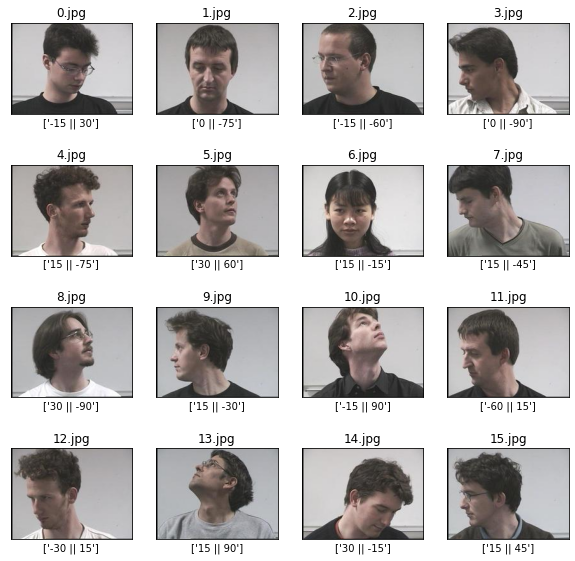

In [24]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = mpimg.imread(str(images_dir)+'/'+train_df['filename'].iloc[i]) # images are color images
    plt.imshow(image)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.title(train_df['filename'].iloc[i])
    plt.xlabel([ str(train_df['tilt'].iloc[i])+' || '+str(train_df['pan'].iloc[i]) ])
#     plt.ylabel(train_df['pan'].iloc[i])
plt.show()

Here our image quite small for NueroNets, So to increase the size of dataset we can use Data Augmentation techniqes.

### One Hot Encoding for both target values

In [25]:
from sklearn.preprocessing import OneHotEncoder

def ohe(x):
    return OneHotEncoder(categories='auto').fit(x.reshape(-1,1)).transform(x.reshape(-1,1)).toarray().astype('int64')

In [26]:
y_tilt = pd.DataFrame(ohe(np.array(train_df.tilt)))
y_tilt.shape

(2925, 9)

In [27]:
y_pan = pd.DataFrame(ohe(np.array(train_df.pan)))
y_pan.shape

(2925, 13)

In [28]:
targets = np.concatenate((y_tilt, y_pan), axis=1)
targets.shape

(2925, 22)

## Train/validation set splis

In [29]:
print("Shape of training dataset:",train_df.shape)

Shape of training dataset: (2925, 5)


In [30]:
def train_test_splits(X,y): 
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=292)
    return x_train, x_val, y_train, y_val

### train/validation split for tilt

In [31]:
X_train, X_val, y_train, y_val = train_test_splits(train_df['filename'], targets)

X_train = [os.path.join(images_dir, str(f)) for f in X_train]
X_val = [os.path.join(images_dir, str(f)) for f in X_val]

y_train = np.array(y_train)
y_val = np.array(y_val)

In [32]:
print("***************************")
print("Splits of Labels")
print("***************************")
print("Size of training: ", len(X_train))
print("Size of validation: ", len(X_val))
print("\n***************************")
print("Input Values:")
print("***************************")
print(X_train[:3])
print("\n***************************")
print("Target Values:")
print("***************************")
print(y_train[:3])

***************************
Splits of Labels
***************************
Size of training:  2340
Size of validation:  585

***************************
Input Values:
***************************
['C:\\Users\\Milind\\DL-Assingment-1/faces\\894.jpg', 'C:\\Users\\Milind\\DL-Assingment-1/faces\\1894.jpg', 'C:\\Users\\Milind\\DL-Assingment-1/faces\\1821.jpg']

***************************
Target Values:
***************************
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


## Data pipeline

In [33]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [34]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [35]:
epoch_size = 32
BUFFER_SIZE = 128
IMG_HEIGHT = 144
IMG_WIDTH = 192
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [36]:
def data_pipeline(X, y):
    filenames = tf.convert_to_tensor(X, dtype=tf.string)
    label1 = tf.convert_to_tensor(y[:, :9])
    label2 = tf.convert_to_tensor(y[:, 9:22])
    dataset = tf.data.Dataset.from_tensor_slices((filenames, (label1, label2)))
    
    def map_fn(path, label):
        # path/label represent values for a single example
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_saturation(image, 0, 4)
        image = tf.image.random_hue(image, 0.3)
        image = tf.cast(image, dtype=tf.float32) / 255.0
        image = tf.reshape(image, [144, 192, 3])
        return image, label

    # num_parallel_calls > 1 induces intra-batch shuffling
    dataset = dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

def creating_test_pipeline(X):
    filenames = tf.convert_to_tensor(X, dtype=tf.string)
    dataset = tf.data.Dataset.from_tensor_slices((filenames))

    def map_test_fn(path):
    # path/label represent values for a single example
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.0
    image = tf.reshape(image, [144, 192, 3])
    return image

    dataset = dataset.map(map_test_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [37]:
train_ds = data_pipeline(X_train,y_train).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = data_pipeline(X_val,y_val).batch(BATCH_SIZE)
test_ds = creating_test_pipeline(test_df.filename).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

In [38]:
train_ds

<BatchDataset shapes: ((None, 144, 192, 3), ((None, 9), (None, 13))), types: (tf.float32, (tf.int64, tf.int64))>

In [39]:
# image, label = next(iter(tilt_train_ds))
# maxValue = np.amax(image)
# minValue = np.amin(image)
# print(minValue, maxValue)
# arr_ = np.squeeze(image)
# label_ = np.squeeze(label)
# plt.imshow(arr_)
# plt.title(label_)
# plt.show()

# Configure the dataset for performance

In [40]:
m_histories = {}

# def get_callbacks(name):
#   return [
#     tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
#   ]

In [41]:
with strategy.scope():    
    model_input = Input(shape=(144, 192, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5),padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(196, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(9, activation='softmax')(x)
    y2 = Dense(13, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=5e-4),
        loss=[tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_crossentropy],
        metrics=['accuracy']
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [42]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Function for decaying the learning rate.
# You can define any decay function you need.
# def decay(epoch):
#   if epoch < 3:
#     return 1e-3
#   elif epoch >= 3 and epoch < 7:
#     return 1e-4
#   else:
#     return 1e-5

# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

call_backs = [
    tf.keras.callbacks.TensorBoard(log_dir=os.getcwd()+'/logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True)
    # tf.keras.callbacks.LearningRateScheduler(decay),
    # PrintLR()
]

In [45]:
epoch_size = 50
m_histories['model_1'] = model.fit(
    train_ds,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    callbacks=call_backs
)


Train for 73 steps, validate for 18 steps
Epoch 1/256
72/73 [============================>.] - ETA: 0s - loss: 0.6056 - dense_1_loss: 0.3494 - dense_2_loss: 0.2562 - dense_1_accuracy: 0.8889 - dense_2_accuracy: 0.9230
Learning rate for epoch 1 is 0.0010000000474974513
73/73 [==============================] - 81s 1s/step - loss: 0.6057 - dense_1_loss: 0.3494 - dense_2_loss: 0.2563 - dense_1_accuracy: 0.8889 - dense_2_accuracy: 0.9230 - val_loss: 0.6058 - val_dense_1_loss: 0.3491 - val_dense_2_loss: 0.2567 - val_dense_1_accuracy: 0.8889 - val_dense_2_accuracy: 0.9231
Epoch 2/256
72/73 [============================>.] - ETA: 0s - loss: 0.6081 - dense_1_loss: 0.3497 - dense_2_loss: 0.2584 - dense_1_accuracy: 0.8889 - dense_2_accuracy: 0.9223
Learning rate for epoch 2 is 0.0010000000474974513
73/73 [==============================] - 76s 1s/step - loss: 0.6082 - dense_1_loss: 0.3497 - dense_2_loss: 0.2585 - dense_1_accuracy: 0.8889 - dense_2_accuracy: 0.9223 - val_loss: 0.6045 - val_dense_1_

KeyboardInterrupt: 

In [ ]:
model.predict(test_ds)

In [ ]:
# shutil.rmtree(train_images_loc)
# shutil.rmtree(test_images_loc)